In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os

drive_root = 'D:\\SEMESTER 4\\PCD\\PROJECT PCD\\GuavaDiseaseDataset'
train_path = os.path.join(drive_root, 'train')

# EDA

In [4]:
import matplotlib.pyplot as plt
import cv2
from collections import Counter

In [5]:
# Jumlah gambar per kelas
train_path = 'GuavaDiseaseDataset\\GuavaDiseaseDataset\\train'
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len([img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png', '.jpeg'))])
        print(f'Kelas {class_name}: {num_images} gambar')

Kelas Anthracnose: 1080 gambar
Kelas fruit_fly: 918 gambar
Kelas healthy_guava: 649 gambar


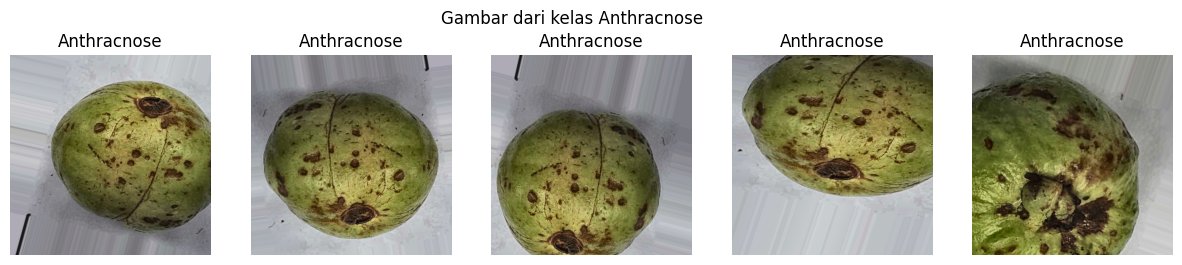

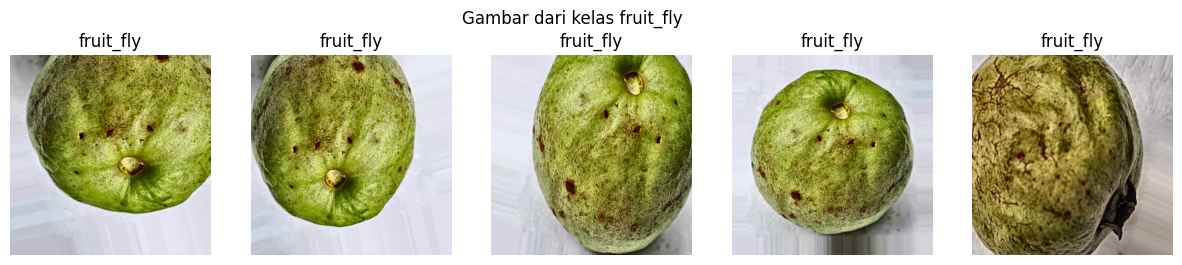

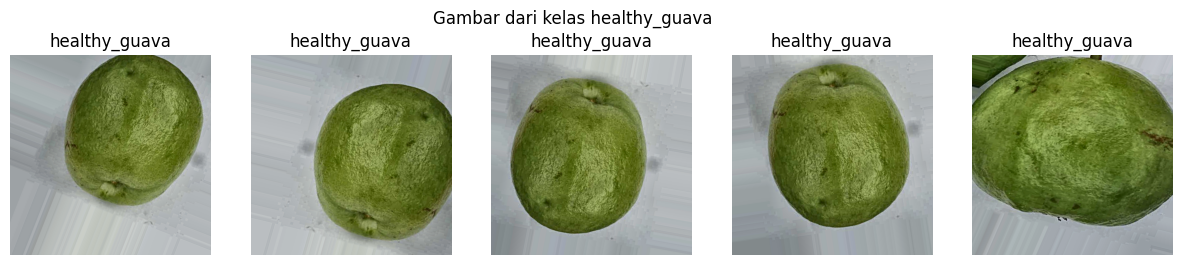

In [6]:
# Contoh gambar dari setiap kelas
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        images = [img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png', '.jpeg'))][:5]
        plt.figure(figsize=(15,3))
        for i, img_name in enumerate(images):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
        plt.suptitle(f'Gambar dari kelas {class_name}')
        plt.show()

In [7]:
# Data ukuran gambar
image_sizes = []

for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            if img_name.endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    h, w, _ = img.shape
                    image_sizes.append((h, w))

size_counts = Counter(image_sizes)

print('Seluruh Ukuran Gambar')
for size, count in size_counts.items():
    print(f'Ukuran: {size}, Jumlah: {count}')

Seluruh Ukuran Gambar
Ukuran: (512, 512), Jumlah: 2647


# Pre processing

In [8]:
import cv2
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

In [9]:
output_path = os.path.join(drive_root, 'train_preprocessed')
os.makedirs(output_path, exist_ok=True)

In [10]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None

    # Resize gambar
    image = cv2.resize(image, (256, 256))

    # Gaussian Blur jika pencahayaan tidak merata
    image_blur = cv2.GaussianBlur(image, (5, 5), 0)

    # Konversi RGB ke HSV (normalisasi warna)
    hsv = cv2.cvtColor(image_blur, cv2.COLOR_BGR2HSV)

    # Median blur untuk menghilangkan noise kecil
    denoised = cv2.medianBlur(hsv, 3)

    # Ambil channel Value (V) dari HSV, karena mengandung informasi intensitas
    _, _, v = cv2.split(denoised)

    # Thresholding Otsu pada channel V
    _, segmented = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return segmented

In [11]:
for class_folder in os.listdir(train_path):
    class_path = os.path.join(train_path, class_folder)
    save_class_path = os.path.join(output_path, class_folder)
    os.makedirs(save_class_path, exist_ok=True)

    for img_name in tqdm(os.listdir(class_path), desc=f"Processing {class_folder}"):
        img_path = os.path.join(class_path, img_name)
        output_img = preprocess_image(img_path)

        if output_img is not None:
            save_path = os.path.join(save_class_path, img_name)
            cv2.imwrite(save_path, output_img)

Processing healthy_guava: 100%|██████████| 649/649 [00:05<00:00, 125.84it/s]


In [12]:
def visualize_all_classes_steps(train_path):
    class_folders = os.listdir(train_path)
    n_classes = len(class_folders)
    fig, axes = plt.subplots(n_classes, 6, figsize=(18, 3 * n_classes))

    for row_idx, class_name in enumerate(class_folders):
        class_folder = os.path.join(train_path, class_name)
        images = os.listdir(class_folder)
        if not images:
            continue

        random_image = random.choice(images)
        image_path = os.path.join(class_folder, random_image)

        image = cv2.imread(image_path)
        image = cv2.resize(image, (128, 128))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_blur = cv2.GaussianBlur(image, (5, 5), 0)

        hsv = cv2.cvtColor(image_blur, cv2.COLOR_BGR2HSV)

        denoised = cv2.medianBlur(hsv, 3)

        _, _, v = cv2.split(denoised)

        _, segmented = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        images_to_plot = [
            image_rgb,
            cv2.cvtColor(image_blur, cv2.COLOR_BGR2RGB),
            cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB),
            cv2.cvtColor(denoised, cv2.COLOR_HSV2RGB),
            v,
            segmented
        ]

        titles = [
            "Asli",
            "Gaussian Blur",
            "HSV",
            "Median Blur",
            "Channel V",
            "Otsu Threshold"
        ]

        for col_idx, img in enumerate(images_to_plot):
            ax = axes[row_idx, col_idx] if n_classes > 1 else axes[col_idx]
            if len(img.shape) == 2:  # Grayscale
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            if row_idx == 0:
                ax.set_title(titles[col_idx], fontsize=10)
            ax.axis('off')
            if col_idx == 0:
                ax.set_ylabel(class_name, fontsize=10)

    plt.tight_layout()
    plt.show()

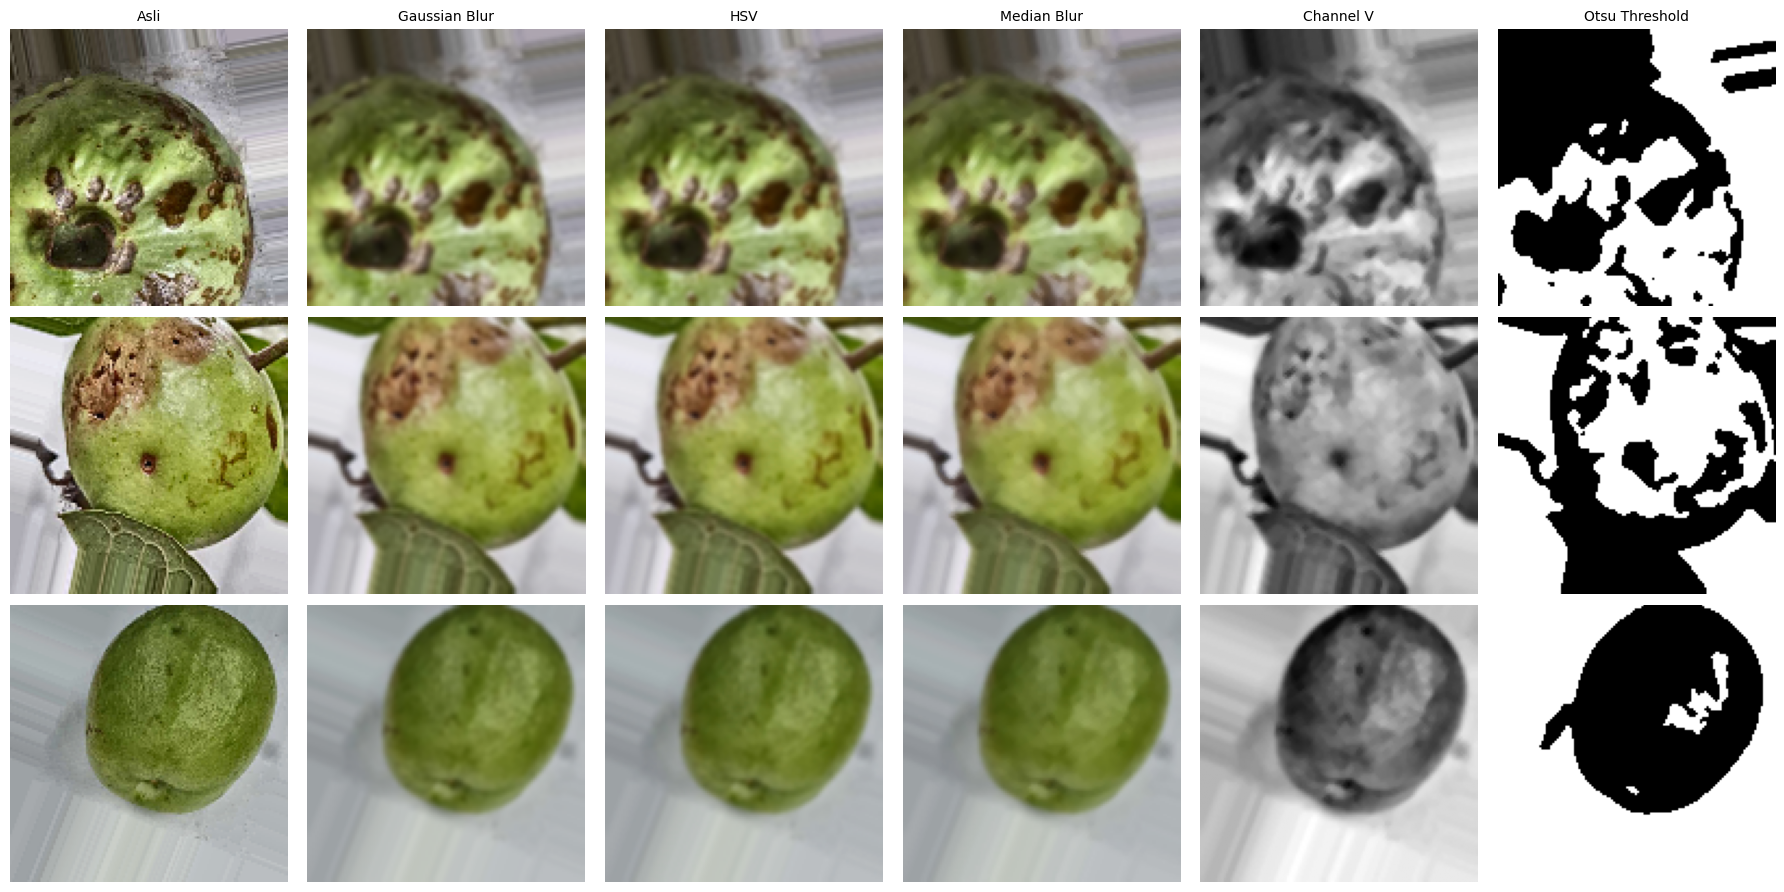

In [13]:
visualize_all_classes_steps(train_path)

# Ekstraksi fitur

In [14]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from skimage.feature import graycomatrix, graycoprops

In [15]:
# !pip install scikit-image -U

In [16]:
import cv2
import numpy as np
import pandas as pd
import os
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import kurtosis, skew
from tqdm import tqdm

def normalize_gray(image):
    """Normalize grayscale image to 8-bit (0–255)"""
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def extract_glcm_features(gray):
    gray = normalize_gray(gray)
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    features = {}
    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    for p in props:
        values = graycoprops(glcm, p).flatten()
        features[f'{p}_mean'] = np.mean(values)
        features[f'{p}_std'] = np.std(values)
    return features

def extract_gabor_features(gray):
    features = {}
    ksize = 21
    idx = 0
    for theta in [0, np.pi/4, np.pi/2, 3*np.pi/4]:
        for sigma in (1, 3):
            for lamda in (np.pi/4, np.pi/2):
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma=0.5, psi=0)
                fimg = cv2.filter2D(gray, cv2.CV_8UC3, kernel)
                features[f'gabor_mean_{idx}'] = np.mean(fimg)
                features[f'gabor_std_{idx}'] = np.std(fimg)
                features[f'gabor_kurt_{idx}'] = kurtosis(fimg.flatten())
                idx += 1
    return features

# Main pipeline
def process_directory(base_dir):
    data = []
    labels = []
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path): continue

        for img_name in tqdm(os.listdir(class_path), desc=f"🔍 {class_name}"):
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')): continue
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)
            if image is None: continue

            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            gray = hsv[:, :, 2]  # Use V channel only

            # Resize for consistency
            gray = cv2.resize(gray, (256, 256))

            glcm_feat = extract_glcm_features(gray)
            gabor_feat = extract_gabor_features(gray)

            combined = {**glcm_feat, **gabor_feat}
            combined['label'] = class_name
            data.append(combined)

    return pd.DataFrame(data)

# Example usage:
# df = process_directory('/content/drive/MyDrive/Dataset PCD/train_preprocessed')
# df.to_csv('fitur_guava_optimized.csv', index=False)


In [17]:
df = process_directory(output_path)
df.to_csv('fitur_guava_optimized.csv', index=False)
df.head()

🔍 healthy_guava: 100%|██████████| 649/649 [02:22<00:00,  4.56it/s]


,contrast_mean,contrast_std,dissimilarity_mean,dissimilarity_std,homogeneity_mean,homogeneity_std,ASM_mean,ASM_std,energy_mean,energy_std,...,gabor_mean_13,gabor_std_13,gabor_kurt_13,gabor_mean_14,gabor_std_14,gabor_kurt_14,gabor_mean_15,gabor_std_15,gabor_kurt_15,label
0,2172.523574,781.944539,8.519700,3.066449,0.966590,0.012025,0.484820,0.010905,0.696246,0.007842,...,6.156937,26.780020,40.558180,124.150604,123.947094,-1.951884,19.735443,52.389040,10.674028,Anthracnose
1,2988.858711,1075.053822,11.721015,4.215897,0.954036,0.016533,0.456859,0.015018,0.675822,0.011132,...,8.079849,30.350897,29.331436,153.460159,120.729364,-1.778794,25.862640,58.405471,7.070276,Anthracnose
2,3115.761418,1142.048194,12.218672,4.478620,0.952084,0.017563,0.486913,0.016316,0.697693,0.011720,...,9.008148,31.977060,26.278883,180.905716,112.100552,-1.099749,28.228699,60.612825,6.090290,Anthracnose
3,2331.983312,857.418551,9.145033,3.362426,0.964138,0.013186,0.466318,0.012198,0.682816,0.008951,...,6.707840,28.181557,38.150986,148.889877,122.804063,-1.850568,20.542480,52.203107,10.449040,Anthracnose
4,3331.562997,1233.554833,13.064953,4.837470,0.948766,0.018970,0.452003,0.016966,0.672193,0.012651,...,9.838516,34.075330,22.750806,155.105362,120.436859,-1.754428,30.412704,64.625316,5.036169,Anthracnose


In [18]:
random.seed(42)

# GLCM
def extract_glcm_features(gray):
    glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], 256, symmetric=True, normed=True)
    features = {
        'contrast': np.mean(graycoprops(glcm, 'contrast')),
        'dissimilarity': np.mean(graycoprops(glcm, 'dissimilarity')),
        'homogeneity': np.mean(graycoprops(glcm, 'homogeneity')),
        'ASM': np.mean(graycoprops(glcm, 'ASM')),
        'energy': np.mean(graycoprops(glcm, 'energy')),
        'correlation': np.mean(graycoprops(glcm, 'correlation')),
    }
    return features

# Gabor
def extract_gabor_features(gray):
    features = {}
    num = 0
    for theta in (0, np.pi/4, np.pi/2, 3*np.pi/4):
        for sigma in (1, 3):
            for lamda in (np.pi/4, np.pi/2):
                kernel = cv2.getGaborKernel((21, 21), sigma, theta, lamda, gamma=0.5, psi=0)
                filtered = cv2.filter2D(gray, cv2.CV_8UC3, kernel)
                features[f'gabor_mean_{num}'] = np.mean(filtered)
                features[f'gabor_std_{num}'] = np.std(filtered)
                num += 1
    return features

In [19]:
base_dir = os.path.join(drive_root, 'train_preprocessed')
output_dir = os.path.join(drive_root, 'train_extraction')
os.makedirs(output_dir, exist_ok=True)

data = []

for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f"Mengekstrak dari kelas: {class_name}")
    all_images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))]

    for img_name in all_images:
        img_path = os.path.join(class_path, img_name)

        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.resize(image, (256, 256))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Ekstraksi fitur
        glcm_features = extract_glcm_features(gray)
        gabor_features = extract_gabor_features(gray)

        combined_features = {**glcm_features, **gabor_features, 'label': class_name}
        data.append(combined_features)

df = pd.DataFrame(data)
csv_path = os.path.join(output_dir, 'fitur_guava.csv')
df.to_csv(csv_path, index=False)

print(f"CSV berhasil disimpan di: {csv_path}")

Mengekstrak dari kelas: Anthracnose


Mengekstrak dari kelas: fruit_fly
Mengekstrak dari kelas: healthy_guava
CSV berhasil disimpan di: D:\SEMESTER 4\PCD\PROJECT PCD\GuavaDiseaseDataset\train_extraction\fitur_guava.csv


In [20]:
df.to_csv(csv_path, index=False)

In [21]:
df

,contrast,dissimilarity,homogeneity,ASM,energy,correlation,gabor_mean_0,gabor_std_0,gabor_mean_1,gabor_std_1,...,gabor_std_11,gabor_mean_12,gabor_std_12,gabor_mean_13,gabor_std_13,gabor_mean_14,gabor_std_14,gabor_mean_15,gabor_std_15,label
0,1397.217773,5.479285,0.978513,0.495689,0.704047,0.955538,111.454926,124.909840,98.443008,115.399525,...,49.066323,120.001434,125.608643,6.156937,26.780020,124.150604,123.947094,19.735443,52.389040,Anthracnose
1,1917.133789,7.518172,0.970517,0.471919,0.686955,0.940975,141.708923,124.470762,123.946793,116.169453,...,60.540529,151.927170,123.016963,8.079849,30.350897,153.460159,120.729364,25.862640,58.405471,Anthracnose
2,1989.479492,7.801880,0.969405,0.503082,0.709274,0.934532,169.976196,117.879305,150.448517,112.181673,...,59.115172,181.319077,113.281490,9.008148,31.977060,180.905716,112.100552,28.228699,60.612825,Anthracnose
3,1503.271484,5.895182,0.976882,0.478179,0.691499,0.953694,141.550690,124.637284,124.467087,116.221821,...,56.648420,147.640976,124.253439,6.707840,28.181557,148.889877,122.804063,20.542480,52.203107,Anthracnose
4,2110.502930,8.276482,0.967544,0.468915,0.684765,0.935049,142.775955,123.793653,123.293243,115.461044,...,61.648023,153.561691,122.272878,9.838516,34.075330,155.105362,120.436859,30.412704,64.625316,Anthracnose
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642,1639.263672,6.428485,0.974791,0.519011,0.720420,0.944759,99.819794,122.134556,85.662659,111.585882,...,55.431493,106.949829,123.844700,7.070084,29.750696,112.895477,122.417563,21.787476,54.883021,healthy_guava
2643,2824.867188,11.077911,0.956558,0.470328,0.685787,0.911009,122.214706,124.119320,101.847565,113.841755,...,66.779932,136.557724,124.289316,12.193146,37.897361,136.866364,121.282736,35.344910,68.966734,healthy_guava
2644,2806.595703,11.006258,0.956839,0.465140,0.681996,0.912559,126.838867,124.419706,106.740326,114.840635,...,67.041500,141.166550,123.975313,12.205582,37.764397,140.057343,122.150875,34.583344,68.834042,healthy_guava
2645,3264.436523,12.801712,0.949798,0.470790,0.686118,0.895757,119.346161,123.528857,98.037582,112.628664,...,73.131387,135.654892,123.820939,12.753464,39.370640,132.302734,122.357789,36.019104,70.595450,healthy_guava


# PCA

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
csv_path = 'fitur_guava_optimized.csv'
df = pd.read_csv(csv_path)

X = df.drop(columns=['label'])
y = df['label']

In [24]:
# Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
pca = PCA(n_components=0.95)  # Variance threshold
X_pca = pca.fit_transform(X_scaled)

# Use the correct number of columns based on X_pca shape
df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca['label'] = y

df_pca

,PC1,PC2,PC3,label
0,-9.858943,0.353567,-1.687965,Anthracnose
1,-3.768265,-1.100929,0.852443,Anthracnose
2,-0.751907,2.247307,1.423280,Anthracnose
3,-7.688315,0.558607,0.927031,Anthracnose
4,-1.451071,-2.167744,0.774442,Anthracnose
...,...,...,...,...
2642,-7.188434,-0.408084,-3.753175,healthy_guava
2643,1.682013,-5.099811,-1.409440,healthy_guava
2644,1.725083,-4.966862,-0.824132,healthy_guava
2645,4.322807,-6.304221,-2.090711,healthy_guava


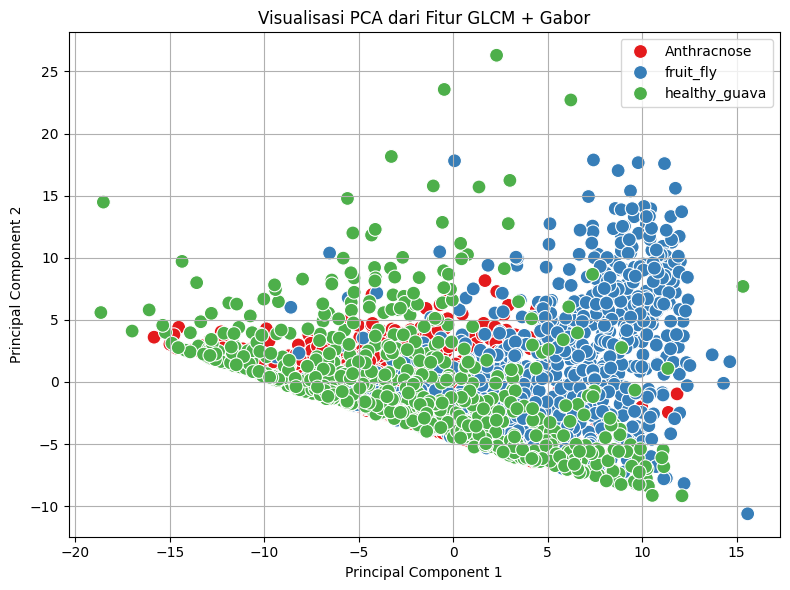

In [26]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', palette='Set1', s=100)
plt.title('Visualisasi PCA dari Fitur GLCM + Gabor')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

X = df.drop(columns=['label'])
y = df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Xgbost

c:\Users\Sinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:15:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier
               precision    recall  f1-score   support

  Anthracnose       0.66      0.78      0.72       216
    fruit_fly       0.74      0.67      0.70       184
healthy_guava       0.68      0.57      0.62       130

     accuracy                           0.69       530
    macro avg       0.69      0.67      0.68       530
 weighted avg       0.69      0.69      0.69       530

Akurasi: 0.690566037735849


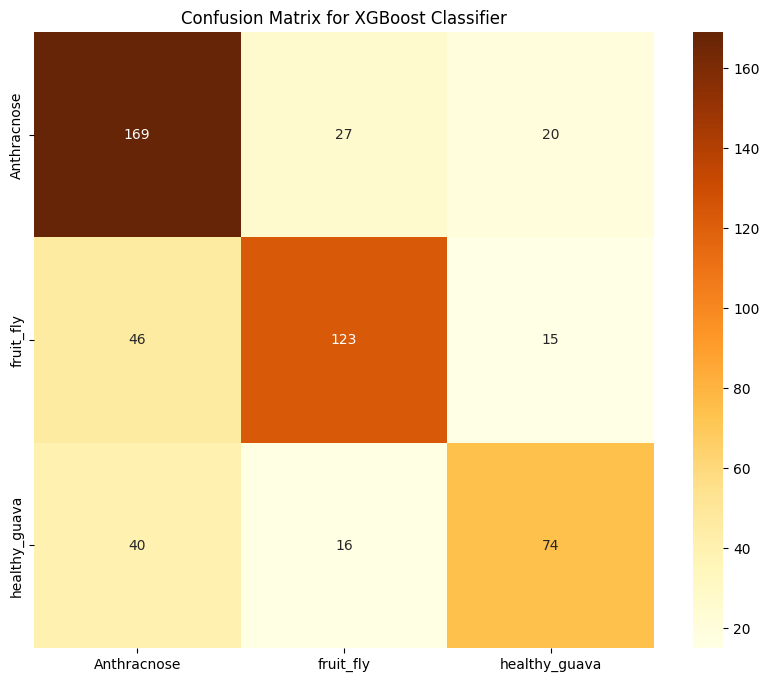

In [39]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_scaled, y_train)
y_pred = xgb_model.predict(X_test_scaled)
print("XGBoost Classifier")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Akurasi:", accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)  
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for XGBoost Classifier')
plt.show()



## Random Forest

Random Forest Classifier
               precision    recall  f1-score   support

  Anthracnose       0.66      0.81      0.73       216
    fruit_fly       0.72      0.67      0.70       184
healthy_guava       0.72      0.52      0.60       130

     accuracy                           0.69       530
    macro avg       0.70      0.67      0.68       530
 weighted avg       0.70      0.69      0.69       530

Confusion Matrix:
 [[176  26  14]
 [ 48 124  12]
 [ 41  22  67]]


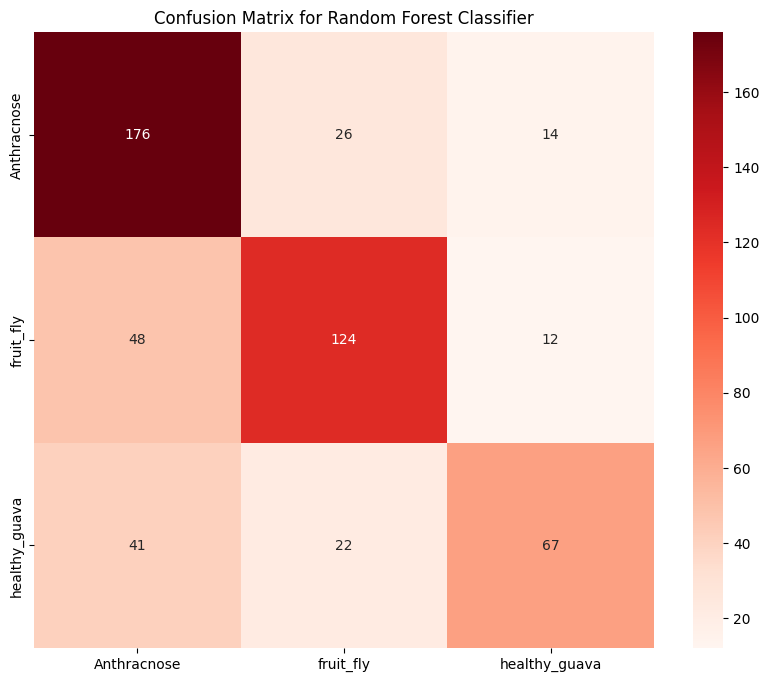

In [43]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("Random Forest Classifier")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))  
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()


## KNN

=== KNN Classification Report ===
               precision    recall  f1-score   support

  Anthracnose       0.61      0.83      0.70       216
    fruit_fly       0.70      0.65      0.67       184
healthy_guava       0.78      0.41      0.54       130

     accuracy                           0.66       530
    macro avg       0.70      0.63      0.64       530
 weighted avg       0.68      0.66      0.65       530

Confusion Matrix:
 [[179  28   9]
 [ 59 119   6]
 [ 55  22  53]]
Accuracy: 66.23%


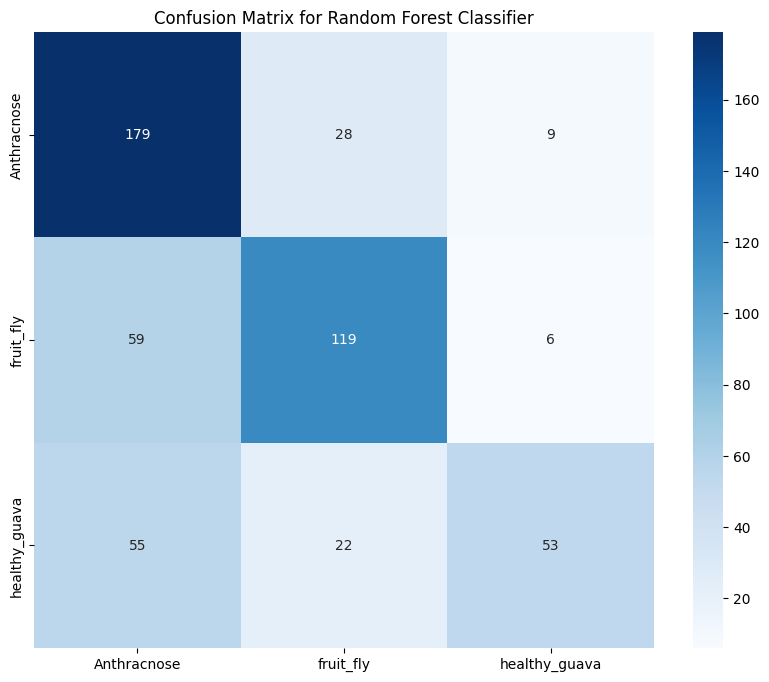

In [42]:

knn = KNeighborsClassifier(n_neighbors=15, metric='euclidean')
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

print("=== KNN Classification Report ===")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_knn)*100))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

## SVM


=== SVM Classification Report ===
               precision    recall  f1-score   support

  Anthracnose       0.76      0.89      0.82       216
    fruit_fly       0.82      0.74      0.78       184
healthy_guava       0.81      0.69      0.75       130

     accuracy                           0.79       530
    macro avg       0.80      0.77      0.78       530
 weighted avg       0.79      0.79      0.79       530

Accuracy: 78.87%


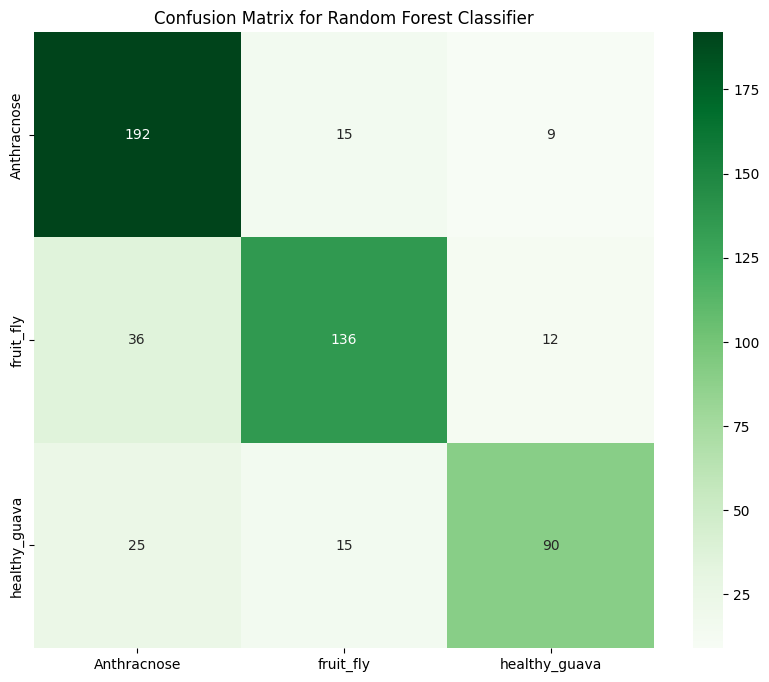

In [44]:

svm = SVC(kernel='rbf', C=5000, gamma='scale')
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

print("\n=== SVM Classification Report ===")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_svm)*100))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

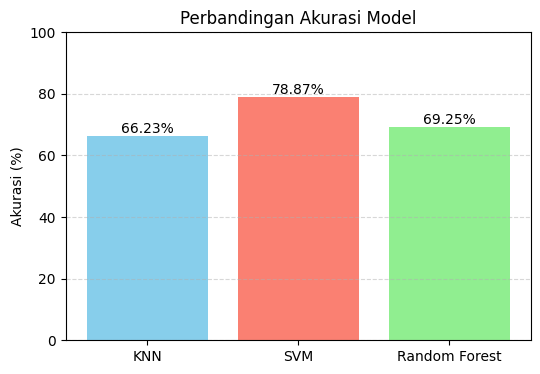

In [45]:
import matplotlib.pyplot as plt

# Hitung akurasi
acc_knn = accuracy_score(y_test, y_pred_knn)
acc_svm = accuracy_score(y_test, y_pred_svm)
acc_rf = accuracy_score(y_test, y_pred_rf)

# Plot
plt.figure(figsize=(6,4))
models = ['KNN', 'SVM', 'Random Forest']
accuracies = [acc_knn, acc_svm, acc_rf]
plt.bar(models, [a * 100 for a in accuracies], color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Perbandingan Akurasi Model")
plt.ylabel("Akurasi (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
for i, acc in enumerate(accuracies):
    plt.text(i, acc * 100 + 1, f"{acc*100:.2f}%", ha='center', fontsize=10)
plt.show()


In [46]:
from sklearn.svm import SVC
import joblib

# Training model
model = SVC(kernel='linear', C=1000, gamma='scale', random_state=42)
model.fit(X_train, y_train)  # ⬅️ penting!

# Simpan model dan scaler
joblib.dump(model, 'model_svm.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [ ]:
# # Load model
# model = joblib.load("model_svm.pkl")  # model harus sudah difit
# scaler = joblib.load("scaler.pkl")    # pastikan juga scaler sesuai data training
